# Notebook for SOLO

In [1]:
import torch
from ops.backbones.resnets import ResNetBackbone
from ops.necks.fpn import FPN
from ops.heads.solo_vanilla_head import SOLOVanillaHead
from ops.heads.solo_decoupled_head import SOLODecoupledHead
from ops.heads.solo_dynamic_head import SOLODynamicHead
from ops.detectors.solo import SOLO
from ops.losses.solo import SOLOLoss
from cisd_dataset import CISDataset
import config

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

## Resnet Backbone

In [6]:
model_name = 'resnet50'
n_class = 2
z_depth = 1
return_layers = [0, 1, 2, 3]

sample = torch.Tensor(1, 3, 256, 256)

backbone = ResNetBackbone(model_name,
                          n_class,
                          z_depth,
                          return_layers,
                          pretrained=True,
                          freeze=False)

In [7]:
out = backbone(sample)

input size torch.Size([1, 3, 256, 256])


In [8]:
for fm in out:
    print(fm.size())

torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 2048, 8, 8])


## Feature Pyramid Network

In [21]:
in_channels = [512, 1024, 2048]
out_channels = 64

fpn = FPN(in_channels,
          out_channels,
          use_deform_conv=False,
          extra_maxpool=False,
          extra_p6p7=False)

sample = (torch.Tensor(1, 512, 32, 32),
          torch.Tensor(1, 1024, 16, 16),
          torch.Tensor(1, 2048, 8, 8))

In [22]:
out = fpn(sample)

In [23]:
for fm in out:
    print(fm.size())

torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])


In [24]:
for key in fpn.state_dict().keys():
    print(key)

lateral_convs.0.weight
lateral_convs.0.bias
lateral_convs.1.weight
lateral_convs.1.bias
lateral_convs.2.weight
lateral_convs.2.bias
fpn_convs.0.weight
fpn_convs.0.bias
fpn_convs.1.weight
fpn_convs.1.bias
fpn_convs.2.weight
fpn_convs.2.bias
fpn_convs.3.weight
fpn_convs.3.bias
fpn_convs.4.weight
fpn_convs.4.bias


## Vanilla SOLO head

In [8]:
in_channels = 64 # out fpn channels
num_groups = 16
grid_number = 32
num_convs = 2
num_up_conv_blocks = 2
num_categories = 2

head = SOLOVanillaHead(in_channels,
                       num_groups,
                       grid_number,
                       num_convs,
                       num_up_conv_blocks,
                       num_categories)

sample = torch.Tensor(2, 64, 32, 32)

In [9]:
out = head(sample)

In [10]:
cat, masks = out
print(cat.size())
print(masks.size())

torch.Size([2, 2, 32, 32])
torch.Size([2, 1024, 128, 128])


## Decoupled SOLO head

In [2]:
in_channels = 64 # out fpn channels
num_groups = 16
grid_number = 32
num_convs = 2
num_up_conv_blocks = 2
num_categories = 2

head = SOLODecoupledHead(in_channels,
                         num_groups,
                         grid_number,
                         num_convs,
                         num_up_conv_blocks,
                         num_categories)

sample = torch.Tensor(2, 64, 64, 64)

In [3]:
out = head(sample)

branch x size torch.Size([2, 32, 256, 256])
branch y size torch.Size([2, 32, 256, 256])
branch x torch.Size([2, 1, 32, 256, 256])
branch x torch.Size([2, 32, 32, 256, 256])
masks size torch.Size([2, 32, 32, 256, 256])
masks size torch.Size([2, 1024, 256, 256])


In [4]:
cat, masks = out
print(cat.size())
print(masks.size())

torch.Size([2, 2, 32, 32])
torch.Size([2, 1024, 256, 256])


## Dynamic SOLO head

In [2]:
in_channels = 64 # out fpn channels
num_groups = 16
grid_number = 32
num_convs = 2
num_up_conv_blocks = 2
num_categories = 2
out_features_branch = 16
out_kernel_branch_filters_size = [3, 3]

head = SOLODynamicHead(in_channels,
                       num_groups,
                       grid_number,
                       num_convs,
                       num_up_conv_blocks,
                       num_categories,
                       out_features_branch,
                       out_kernel_branch_filters_size)

sample = torch.Tensor(2, 64, 64, 64)

In [3]:
out = head(sample)

In [4]:
cat, masks = out
print(cat.size())
print(masks.size())

torch.Size([2, 2, 32, 32])
torch.Size([2, 1024, 256, 256])


## SOLO network

In [2]:
model_name = 'resnet18'
n_class = 2
z_depth = 1
return_layers = [0, 1, 2, 3]

sample = torch.Tensor(3, 3, 256, 256)

backbone = ResNetBackbone(model_name,
                          n_class,
                          z_depth,
                          return_layers,
                          pretrained=True,
                          freeze=False)

# in_channels = [256, 512, 1024, 2048]
in_channels = [64, 128, 256, 512]
out_channels = 64

fpn = FPN(in_channels,
          out_channels,
          use_deform_conv=False,
          extra_maxpool=False,
          extra_p6p7=False)

num_groups = 16
grid_number = 32
num_convs = 2
num_up_conv_blocks = 2
out_features_branch = 32
out_kernel_branch_filters_size = [3, 3]

# head = SOLOVanillaHead(out_channels,
#                        num_groups,
#                        grid_number,
#                        num_convs,
#                        num_up_conv_blocks,
#                        n_class)

# head = SOLODecoupledHead(out_channels,
#                          num_groups,
#                          grid_number,
#                          num_convs,
#                          num_up_conv_blocks,
#                          n_class)

head = SOLODynamicHead(out_channels,
                       num_groups,
                       grid_number,
                       num_convs,
                       num_up_conv_blocks,
                       n_class,
                       out_features_branch,
                       out_kernel_branch_filters_size)

fpn_level_to_use = [0]

solo = SOLO(backbone, fpn, head, fpn_level_to_use)

In [3]:
output = solo(sample, training=True)

In [4]:
cat, masks = output
print('category vector sizes:')
for c in cat:
    print(c.size())
print('mask sizes:')
for m in masks:
    print(m.size())

category vector sizes:
torch.Size([3, 2, 32, 32])
mask sizes:
torch.Size([3, 1024, 256, 256])


## SOLO Loss

Where everything happens

In [3]:
loss = SOLOLoss(num_classes=2,
                pyramid_levels=[0,1],
                scale_ranges=((0, 0.75), (0.25, 1)),
                epsilon=0.2,
                lambda_mask=3,
                gamma=0)

In [4]:
def collater(data):
    imgs, bboxes, labels, masks = [], [], [], []
    for sample in data:
        imgs.append(sample[0])
        bboxes.append(sample[1])
        labels.append(sample[2])
        masks.append(sample[3])
    return torch.stack(imgs, 0), bboxes, labels, masks

trainset = CISDataset(config.DATA_JSON,
                      img_folder=config.IMG_FOLDER,
                      traindevtest='train',
                      augment=True,
                      split=0,
                      use_stack=False)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=3,
                                          shuffle=False,
                                          collate_fn=collater,
                                          pin_memory=True)

after backbone:
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 1024, 16, 16])
torch.Size([3, 2048, 8, 8])
after fpn:
torch.Size([3, 64, 64, 64])
torch.Size([3, 64, 32, 32])
torch.Size([3, 64, 16, 16])
torch.Size([3, 64, 8, 8])
--- end of solo output ---



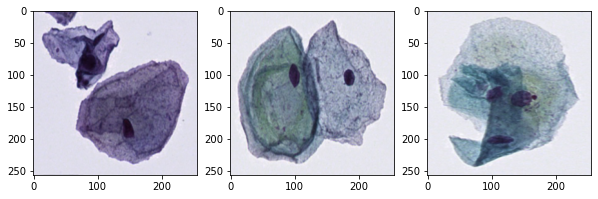

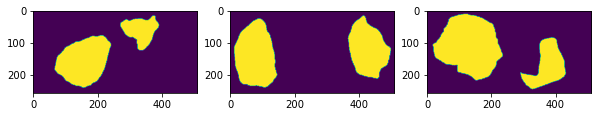

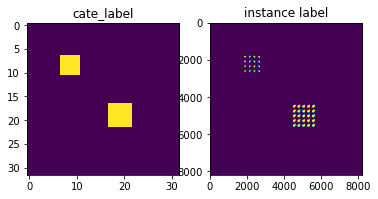

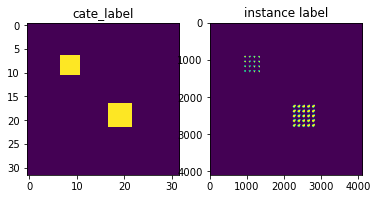

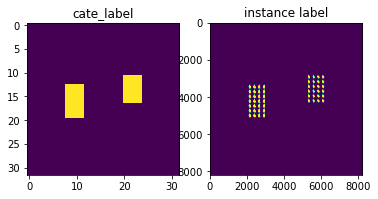

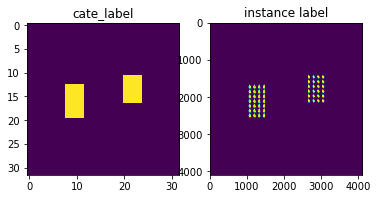

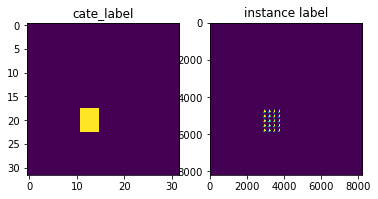

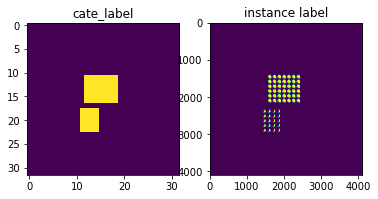

In [5]:
for inputs, bboxes, labels, masks in trainloader:
    output = solo(inputs, training=True)
    print('--- end of solo output ---\n')
    
    # --- show inputs
    viz = inputs.detach().cpu().numpy().squeeze()
    viz = np.moveaxis(viz, 1, -1)
    plt.figure(figsize=(10,6))
    batch_size = viz.shape[0]
    for batch_elem in range(batch_size):
        plt.subplot(1, batch_size, batch_elem+1)
        plt.imshow(viz[batch_elem, ...])
    plt.show()
    # --- show ground truth
    plt.figure(figsize=(10,6))
    for batch_elem in range(batch_size):
        viz = masks[batch_elem].detach().cpu().numpy().squeeze()
        viz = np.concatenate([viz[i, ...] for i in range(viz.shape[0])], axis=1)
        plt.subplot(1, batch_size, batch_elem+1)
        plt.imshow(viz)
    plt.show()
    
    total_loss, cat_loss, mask_loss = loss.forward(output, bboxes, labels, masks)
    break

In [6]:
print(total_loss)
print(cat_loss)
print(mask_loss)

tensor(2.7693, grad_fn=<AddBackward0>)
tensor(0.7880, grad_fn=<MeanBackward0>)
tensor(1.9813, grad_fn=<MulBackward0>)


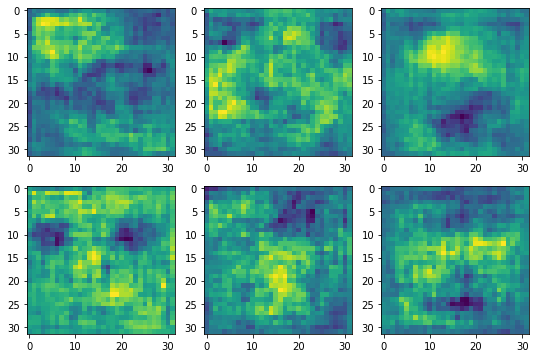

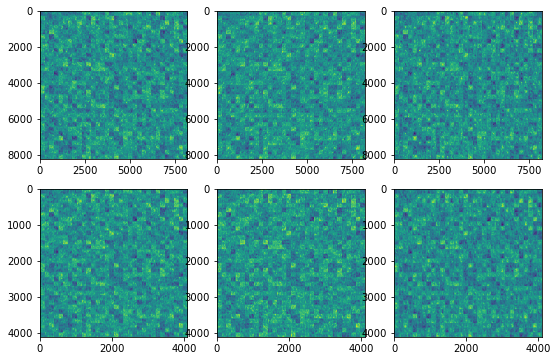

In [22]:
pred_cat, pred_masks = output

n_pyramid_level = len(pred_cat)
batch_size = pred_cat[0].size(0)

plt.figure(figsize=(9,6))
count = 1
for lvl in range(n_pyramid_level):
    for b in range(batch_size):
        p = pred_cat[lvl].detach().cpu().numpy()[b, 1, :, :]
        plt.subplot(n_pyramid_level, batch_size, count)
        plt.imshow(p)
        count += 1
plt.show()

plt.figure(figsize=(9,6))
count = 1
for lvl in range(n_pyramid_level):
    for b in range(batch_size):
        p = pred_masks[lvl].detach().cpu().numpy()[b, ...]
        h, w = p.shape[-2:]
        p = p.reshape(32, 32, h, w)
        p = np.concatenate([p[i, ...] for i in range(p.shape[0])], axis=-2)
        p = np.concatenate([p[i, ...] for i in range(p.shape[0])], axis=-1)
        plt.subplot(n_pyramid_level, batch_size, count)
        plt.imshow(p)
        count += 1
plt.show()

## Evaluation function

Test of the evaluation function, involving postprocessing on model predictions, and evaluation metric computation

In [2]:
from importlib import reload
import os
import train
import config
import torch

In [3]:
reload(train)
reload(config)

<module 'config' from '/home/a_bouyssoux/3DSlidesAnalysis/instanceseg/src/instanceseg/solo/config.py'>

### Load model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = train.load_solo_model()
weight_path = os.path.join(config.WEIGHT_SAVEPATH, config.MODEL_NAME)
model.load_state_dict(torch.load(weight_path))
model = model.to(device)

### Load Criterion

In [5]:
criterion = SOLOLoss(num_classes=2,
                     pyramid_levels=[0],
                     scale_ranges=((0, 1),),
                     epsilon=0.2,
                     lambda_mask=3,
                     gamma=0)

### Load Dataloader

In [6]:
DATA_JSON = '/home/a_bouyssoux/3DSlidesAnalysis/Data/Datasets/instance_segmentation/miniCISD/miniCISD.json'
IMG_FOLDER = '/home/a_bouyssoux/3DSlidesAnalysis/Data/Datasets/instance_segmentation/miniCISD/edf'

def collater(data):
    imgs, bboxes, labels, masks = [], [], [], []
    for sample in data:
        imgs.append(sample[0])
        bboxes.append(sample[1])
        labels.append(sample[2])
        masks.append(sample[3])
    return torch.stack(imgs, 0), bboxes, labels, masks

devset = CISDataset(DATA_JSON,
                    img_folder=IMG_FOLDER,
                    traindevtest='dev',
                    augment=False,
                    split=0,
                    use_stack=False)

devloader = torch.utils.data.DataLoader(
    devset,
    batch_size=1,
    shuffle=False,
    collate_fn=collater,
    pin_memory=True)

print('[INFO] : number of elements in devloader', len(devloader))

[INFO] : number of elements in devloader 733


### Evaluation function

In [11]:
train.evaluation(model, devloader, criterion, run=None)

0.15131330490112305
0.14679789543151855
0.14580225944519043
0.1066892147064209
0.12849140167236328
0.10589313507080078
0.11571455001831055
0.1236724853515625
0.11664557456970215
0.11128807067871094
0.13689947128295898
0.11694478988647461
0.11452960968017578
0.11279869079589844
0.13995599746704102
0.1186680793762207
0.11231803894042969
0.11679339408874512
0.1151125431060791
0.11305022239685059
0.13076448440551758
0.11569070816040039
0.11825966835021973
0.11736536026000977
0.17200994491577148
0.10119438171386719
0.11148691177368164
0.11184406280517578
0.13484764099121094
0.10703873634338379
0.12452197074890137
0.10562825202941895
0.10909628868103027
0.11048007011413574
0.14173293113708496
0.10850644111633301
0.12733125686645508
0.12604761123657227
0.12591266632080078
0.11531853675842285
0.1518082618713379
0.10663747787475586
0.12142729759216309
0.11379885673522949
0.13363218307495117
0.10845375061035156
0.12696003913879395
0.12610268592834473
0.12334299087524414
0.12375044822692871
0.115

KeyboardInterrupt: 

# Evaluation Visualisation

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import img_as_float32, transform
import torch
import torch.nn as nn

import volumeio

# local imports:
import test, config
import cisd_dataset
from eval_utils import Postprocess
import utils

In [2]:
JSON_PATH = '/home/a_bouyssoux/3DSlidesAnalysis/Data/Datasets/instance_segmentation/miniCISD/miniCISD.json'
DATA_PATH = '/home/a_bouyssoux/3DSlidesAnalysis/Data/Datasets/instance_segmentation/miniCISD'
SAMPLE = 'edf'

if SAMPLE == 'edf':
    IMG_FOLDER = os.path.join(DATA_PATH, 'edf')
    Z_DEPTH = 1
elif SAMPLE == 'center':
    IMG_FOLDER = os.path.join(DATA_PATH, 'center_slice')
    Z_DEPTH = 1
elif SAMPLE == 'stack':
    IMG_FOLDER = os.path.join(DATA_PATH, 'samples')
else:
    raise ValueError('sample should be either edf, center or stack')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### model definition

In [4]:
model = test.load_solo_model()
model_weights = os.path.join(config.WEIGHT_SAVEPATH, config.MODEL_NAME)
if os.path.exists(model_weights):
    model.load_state_dict(torch.load(model_weights))
else:
    raise FileNotFoundError('Model weights are not available')
model.eval()
model.to(device)

SOLO(
  (backbone): ResNetBackbone(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

### utils fonctions

In [5]:
def _get_assets():
    with open(config.DATA_JSON, 'r') as f:
        data = json.load(f)
    return [a for a in data['assets'] if a['set'] == 'test']


def get_test_cell_names():
    return [asset['file_name'] for asset in _get_assets()]


def rle2mask(rle):
    values = [i % 2 for i in range(len(rle['counts']))]
    mask = []
    [mask.extend([x] * y) for x,y in zip(values, rle['counts'])]
    return np.array(mask, bool).reshape(rle['size'])

In [6]:
get_test_cell_names()

['0241_BB_01471.jpg',
 '0246_BE_00685.jpg',
 '0238_AY_01638.jpg',
 '0253_AS_01418.jpg',
 '0230_K_00556.jpg',
 '0248_BF_00915.jpg',
 '0234_BC_00777.jpg',
 '0236_BD_01173.jpg',
 '0251_AT_00883.jpg',
 '0230_K_00699.jpg',
 '0256_K1_00586.jpg',
 '0244_BE_01772.jpg',
 '0248_BF_01334.jpg',
 '0235_BD_01451.jpg',
 '0241_BB_01278.jpg',
 '0239_AY_01249.jpg',
 '0250_AT_01850.jpg',
 '0257_K1_01338.jpg',
 '0232_BC_00855.jpg',
 '0246_BE_00992.jpg',
 '0255_AS_01685.jpg',
 '0242_BB_01041.jpg',
 '0237_BD_01254.jpg',
 '0248_BF_01486.jpg',
 '0237_BD_01508.jpg',
 '0241_BB_01719.jpg',
 '0231_K_00914.jpg',
 '0244_BE_01260.jpg',
 '0249_BF_00818.jpg',
 '0238_AY_00648.jpg',
 '0231_K_00829.jpg',
 '0233_BC_01018.jpg',
 '0257_K1_00809.jpg',
 '0231_K_00933.jpg',
 '0257_K1_00644.jpg',
 '0251_AT_01035.jpg',
 '0234_BC_01339.jpg',
 '0238_AY_00823.jpg',
 '0240_AY_00786.jpg',
 '0235_BD_01155.jpg',
 '0236_BD_01105.jpg',
 '0255_AS_01243.jpg',
 '0246_BE_01030.jpg',
 '0236_BD_01606.jpg',
 '0232_BC_00512.jpg',
 '0251_AT_01152

In [6]:
def predict_on_cell(model, cell_name, return_gt=True):
    # --- return img
    if config.Z_DEPTH > 1:
        img = volumeio.load(os.path.join(IMG_FOLDER, cell_name))
    else:
        img = imageio.imread(os.path.join(IMG_FOLDER, cell_name))
    img = img_as_float32(img)
    H = img.shape[0]
    W = img.shape[1]
        
    print('[INFO]: img shape', img.shape)
    # --- create tensor from img
    tr = cisd_dataset.get_transforms(augment=False)
    tensor = tr(img).unsqueeze(0)
    tensor = tensor.to(device)
    print('[INFO]: tensor shape', tensor.shape)
    # --- predict cytoplasms
    postprocessor = Postprocess(n_class=config.PARAMS['n class'],
                                top_k=config.PARAMS['top_k'],
                                conf_thresh=config.PARAMS['conf_thresh'],
                                nms_thresh=config.PARAMS['nms_thresh'])
    
    with torch.no_grad():
        pred_cat, pred_masks = model(tensor, training=False)
        
        pos_scores, pos_labels, pos_masks = [], [], []
        # iterate through pyramid levels
        for p_level in range(len(pred_cat)):
            categories = pred_cat[p_level].squeeze(0) # size (n_class, S, S)
            lvl_masks = pred_masks[p_level].squeeze(0) # size (S**2, H, W)
            categories = categories.permute(1, 2, 0) # -> (S, S, n_class)
            categories = categories.reshape([-1, categories.size(-1)]) # -> (S*S, n_class)
            categories = nn.Softmax(dim=-1)(categories)
            scores, labels = torch.max(categories, axis=-1)

            pos = labels > 0 # Select positive instances
            pos_scores.append(scores[pos])
            pos_labels.append(labels[pos])
            pos_masks.append(lvl_masks[pos])

        # Float masks to binary masks, decision threshold is then 0.5
        pos_masks = [torch.round(pos_mask) for pos_mask in pos_masks]

        pos_scores = torch.cat(pos_scores)
        pos_labels = torch.cat(pos_labels)
        pos_masks = torch.cat(pos_masks)

        if pos_scores.numel() > 0: # there is at least one instance detected
            pos_masks, pos_scores, pos_labels = postprocessor(
                pos_masks, pos_scores, pos_labels)
        else:
            pos_masks = np.zeros(0)
            pos_scores = np.zeros(0)
            pos_labels = np.zeros(0)
            
    print('[INFO]: pos masks shape', pos_masks.shape)
    pos_masks = transform.resize(pos_masks, (pos_masks.shape[0], H, W))
    
    # --- return gt
    if return_gt:
        assets = _get_assets()
        for asset in assets:
            if asset['file_name'] == cell_name:
                break
        objects = asset['annotations'][0]['data']
        gt = np.stack([rle2mask(o['mask']) for o in objects], axis=0)
    else:
        gt = None
    return img, pos_masks, gt

    
def vis_prediction(img, pred, cell_name, savepath=None):
    res = utils.visualize.instance_viz(img, pred)
    plt.figure(frameon=False)
    plt.axis('off')
    plt.imshow(res)
    if savepath is not None:
        cell_id = os.path.splitext(cell_name)[0]
        savename = os.path.join(savepath, f'solo_{cell_id}.png')
        plt.savefig(savename, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

[INFO]: img shape (330, 444, 3)
[INFO]: tensor shape torch.Size([1, 3, 256, 256])
[INFO]: pos masks shape (2, 256, 256)


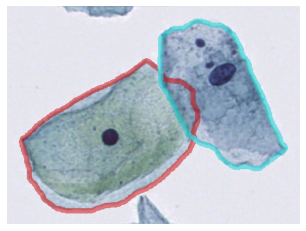

In [15]:
cell_name = '0256_K1_00586.jpg'
savepath = '/home/a_bouyssoux/3DSlidesAnalysis/instanceseg/illustrations/results'
img, seg, _ = predict_on_cell(model, cell_name, return_gt=False)
vis_prediction(img, seg, cell_name, savepath=savepath)